In [23]:
import pandas as pd
import numpy as np

# --- 1) Les inn og klargjør fylkesdata ---
file_fylke = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/biostat-total-flk.csv"
df_fylke = pd.read_csv(file_fylke, sep=";", decimal=".", na_values=["(null)"])
df_fylke = df_fylke[df_fylke["ARTSID"] == "LAKS"].copy()

df_fylke['Dato'] = pd.to_datetime(
    df_fylke['ÅR'].astype(str) + '-' + df_fylke['MÅNED_KODE'].astype(str),
    format='%Y-%m', errors='coerce'
) + pd.offsets.MonthEnd(0)

df_fylke = df_fylke.dropna(subset=['FYLKE'])
df_fylke = df_fylke[df_fylke['FYLKE'] != 'Uoppgitt'].copy()

drop_cols = ['ÅR', 'MÅNED_KODE', 'MÅNED', 'UTSETTSÅR', 'ARTSID',
             "UTSETT_SMOLT_STK", 'UTSETT_SMOLT_STK_MINDRE_ENN_500G', 'UTTAK_STK',
             'UTTAK_KG', 'UTTAK_SLØYD_KG', 'UTTAK_HODEKAPPET_KG', 'UTTAK_RUNDVEKT_KG',
             'UTKAST_STK', 'RØMMING_STK', 'ANDRE_STK']
df_fylke = df_fylke.drop(columns=[col for col in drop_cols if col in df_fylke.columns])

df_fylke['% Dødfisk'] = df_fylke['DØDFISK_STK'] / df_fylke['BEHFISK_STK'] * 100

# --- 2) Les inn og klargjør PO-data ---
file_po = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/biostat-total-omr.csv"
df_po = pd.read_csv(file_po, sep=";", decimal=".", na_values=["(null)"])
df_po = df_po[df_po["ARTSID"] == "LAKS"].copy()

df_po['Dato'] = pd.to_datetime(
    df_po['ÅR'].astype(str) + '-' + df_po['MÅNED_KODE'].astype(str),
    format='%Y-%m', errors='coerce'
) + pd.offsets.MonthEnd(0)

df_po = df_po.dropna(subset=['PO_KODE'])
df_po.rename(columns={'PO_KODE': 'PO'}, inplace=True)

drop_cols_po = ['ÅR', 'MÅNED_KODE', 'MÅNED', 'PO_NAVN', 'UTSETTSÅR', 'ARTSID',
                "UTSETT_SMOLT_STK", 'UTSETT_SMOLT_STK_MINDRE_ENN_500G', 'UTTAK_STK',
                'UTTAK_KG', 'UTTAK_SLØYD_KG', 'UTTAK_HODEKAPPET_KG', 'UTTAK_RUNDVEKT_KG',
                'UTKAST_STK', 'RØMMING_STK', 'ANDRE_STK']
df_po = df_po.drop(columns=[col for col in drop_cols_po if col in df_po.columns])

df_po = df_po.groupby(['Dato', 'PO'], as_index=False).agg({
    'BEHFISK_STK': 'sum',
    'BIOMASSE_KG': 'sum',
    'FORFORBRUK_KG': 'sum',
    'DØDFISK_STK': 'sum'
})

# --- 3) Mapping mellom fylke og PO ---
fylke_til_po_map = {
    'Rogaland og Agder': [1, 2],
    'Vestland': [3, 4],
    'Møre og Romsdal': [5, 6],
    'Trøndelag': [6, 7],
    'Nordland': [7, 8, 9, 10],
    'Troms og Finnmark': [10, 11, 12, 13],
    'Troms': [10, 11],
    'Finnmark': [12, 13],
}
po_to_fylke = {po: fylke for fylke, pos in fylke_til_po_map.items() for po in pos}
df_po['FYLKE'] = df_po['PO'].map(po_to_fylke)

# --- 4) Finn PO-andeler i hvert fylke for 2017 ---
df_po_2017 = df_po[df_po['Dato'].dt.year == 2017]
po_andeler = (
    df_po_2017.groupby(['FYLKE', 'PO'])['BIOMASSE_KG'].sum()
    .groupby('FYLKE', group_keys=False)
    .apply(lambda x: x / x.sum())
    .reset_index(name='andel')
)

# --- 5) Fordel fylkesdata 2012-2016 til PO-nivå ---
hist = df_fylke[df_fylke['Dato'] < '2017-01-01'].copy()
pred_list = []
for _, row in hist.iterrows():
    fylke = row['FYLKE']
    po_i_fylke = po_andeler[po_andeler['FYLKE'] == fylke]
    for _, po_row in po_i_fylke.iterrows():
        pred_list.append({
            'Dato': row['Dato'],
            'FYLKE': fylke,
            'PO': po_row['PO'],
            'BIOMASSE_KG': row['BIOMASSE_KG'] * po_row['andel'],
            'DØDFISK_STK': row['DØDFISK_STK'] * po_row['andel'],
            'BEHFISK_STK': row['BEHFISK_STK'] * po_row['andel'],
            'FORFORBRUK_KG': row['FORFORBRUK_KG'] * po_row['andel'],
        })
hist_po = pd.DataFrame(pred_list)

# --- 6) Slå sammen med faktiske PO-data ---
df_full = pd.concat([df_po, hist_po], ignore_index=True).sort_values(['PO', 'Dato'])
df_full = df_full[df_full['Dato'] >= '2012-01-01']
# Finn PO-andeler for hvert år 2017-2024
po_andeler_alle = (
    df_po[df_po['Dato'].dt.year >= 2017]
    .assign(År=lambda x: x['Dato'].dt.year)
    .groupby(['FYLKE', 'År', 'PO'])['BIOMASSE_KG'].sum()
    .groupby(['FYLKE', 'År'], group_keys=False)
    .apply(lambda x: x / x.sum())
    .reset_index(name='andel')
)

# Ekstrapoler PO-andelene bakover for hvert PO i hvert fylke (f.eks. lineært)
# Her er et enkelt eksempel for å bruke første års andel for alle tidligere år:
po_andeler_tidlig = (
    po_andeler_alle
    .sort_values('År')
    .groupby(['FYLKE', 'PO'])
    .first()
    .reset_index()
)

# Lag prediksjonsramme for 2012-2016
hist = df_fylke[df_fylke['Dato'] < '2017-01-01'].copy()
hist['År'] = hist['Dato'].dt.year

pred_list = []
for _, row in hist.iterrows():
    fylke = row['FYLKE']
    po_i_fylke = po_andeler_tidlig[po_andeler_tidlig['FYLKE'] == fylke]
    for _, po_row in po_i_fylke.iterrows():
        pred_list.append({
            'Dato': row['Dato'],
            'FYLKE': fylke,
            'PO': po_row['PO'],
            'BIOMASSE_KG': row['BIOMASSE_KG'] * po_row['andel'],
            'DØDFISK_STK': row['DØDFISK_STK'] * po_row['andel'],
            'BEHFISK_STK': row['BEHFISK_STK'] * po_row['andel'],
            'FORFORBRUK_KG': row['FORFORBRUK_KG'] * po_row['andel'],
        })
hist_po = pd.DataFrame(pred_list)

# Finn gjennomsnittlig andel per fylke, PO og måned
df_po['month'] = df_po['Dato'].dt.month
df_po['year'] = df_po['Dato'].dt.year
df_po = df_po[df_po['year'] >= 2017]

# Summer på fylke, PO, måned
po_month_sum = df_po.groupby(['FYLKE', 'PO', 'month'])['BIOMASSE_KG'].sum().reset_index()
fylke_month_sum = df_po.groupby(['FYLKE', 'month'])['BIOMASSE_KG'].sum().reset_index()
po_month_sum = po_month_sum.merge(fylke_month_sum, on=['FYLKE', 'month'], suffixes=('', '_fylke'))
po_month_sum['andel'] = po_month_sum['BIOMASSE_KG'] / po_month_sum['BIOMASSE_KG_fylke']

# Fordel fylkesdata for 2012–2016
hist = df_fylke[df_fylke['Dato'].dt.year < 2017].copy()
hist['month'] = hist['Dato'].dt.month

pred_list = []
for _, row in hist.iterrows():
    fylke = row['FYLKE']
    month = row['month']
    po_i_fylke = po_month_sum[(po_month_sum['FYLKE'] == fylke) & (po_month_sum['month'] == month)]
    for _, po_row in po_i_fylke.iterrows():
        pred_list.append({
            'Dato': row['Dato'],
            'FYLKE': fylke,
            'PO': po_row['PO'],
            'BIOMASSE_KG': row['BIOMASSE_KG'] * po_row['andel'],
            'DØDFISK_STK': row['DØDFISK_STK'] * po_row['andel'],
            'BEHFISK_STK': row['BEHFISK_STK'] * po_row['andel'],
            'FORFORBRUK_KG': row['FORFORBRUK_KG'] * po_row['andel'],
        })
hist_po = pd.DataFrame(pred_list)
print(df_full.head())

           Dato   PO   BEHFISK_STK   BIOMASSE_KG  FORFORBRUK_KG   DØDFISK_STK  \
3553 2012-01-31  1.0  1.703458e+06  6.562798e+06  922007.116441   9676.089565   
3555 2012-01-31  1.0  2.790895e+06  2.257293e+06  420476.397915  16295.168895   
3557 2012-01-31  1.0  3.235912e+02  1.780464e+01      13.542363      2.993575   
3576 2012-02-29  1.0  1.384244e+06  5.682705e+06  669913.892858  11021.202579   
3578 2012-02-29  1.0  2.770781e+06  2.539499e+06  326925.469924  17896.161292   

                  FYLKE  
3553  Rogaland og Agder  
3555  Rogaland og Agder  
3557  Rogaland og Agder  
3576  Rogaland og Agder  
3578  Rogaland og Agder  


In [24]:
#lager en tetthetsvariabel
#legger til tetthet i PO som kolonne km^2
arealPO1 = 4598
arealPO2 = 2439
arealPO3 = 5681
arealPO4 = 7138
arealPO5 = 7138
arealPO6 = 12308
arealPO7 = 5412
arealPO8 = 13106
arealPO9 = 16740
arealPO10 = 4795
arealPO11 = 7108
arealPO12 = 11196
arealPO13 = 4172

# --- Lag en mapping fra PO til areal ---
po_areal_map = {
    1: arealPO1, 2: arealPO2, 3: arealPO3, 4: arealPO4, 5: arealPO5,
    6: arealPO6, 7: arealPO7, 8: arealPO8, 9: arealPO9, 10: arealPO10,
    11: arealPO11, 12: arealPO12, 13: arealPO13
}

# --- Beregn Tetthet for df_full ved å bruke mappingen ---
# Map PO-nummer til tilhørende areal
df_full['Areal_PO'] = df_full['PO'].map(po_areal_map)

# Beregn Tetthet (Biomasse / Areal)
# Bruk .replace(0, pd.NA) for å unngå divisjon med null hvis et areal er 0
df_full['Tetthet'] = (df_full['BIOMASSE_KG'] / df_full['Areal_PO'].replace(0, pd.NA)).fillna(0)
# Fjern hjelpekolonnen for areal hvis ønskelig
df_full = df_full.drop(columns=['Areal_PO'])

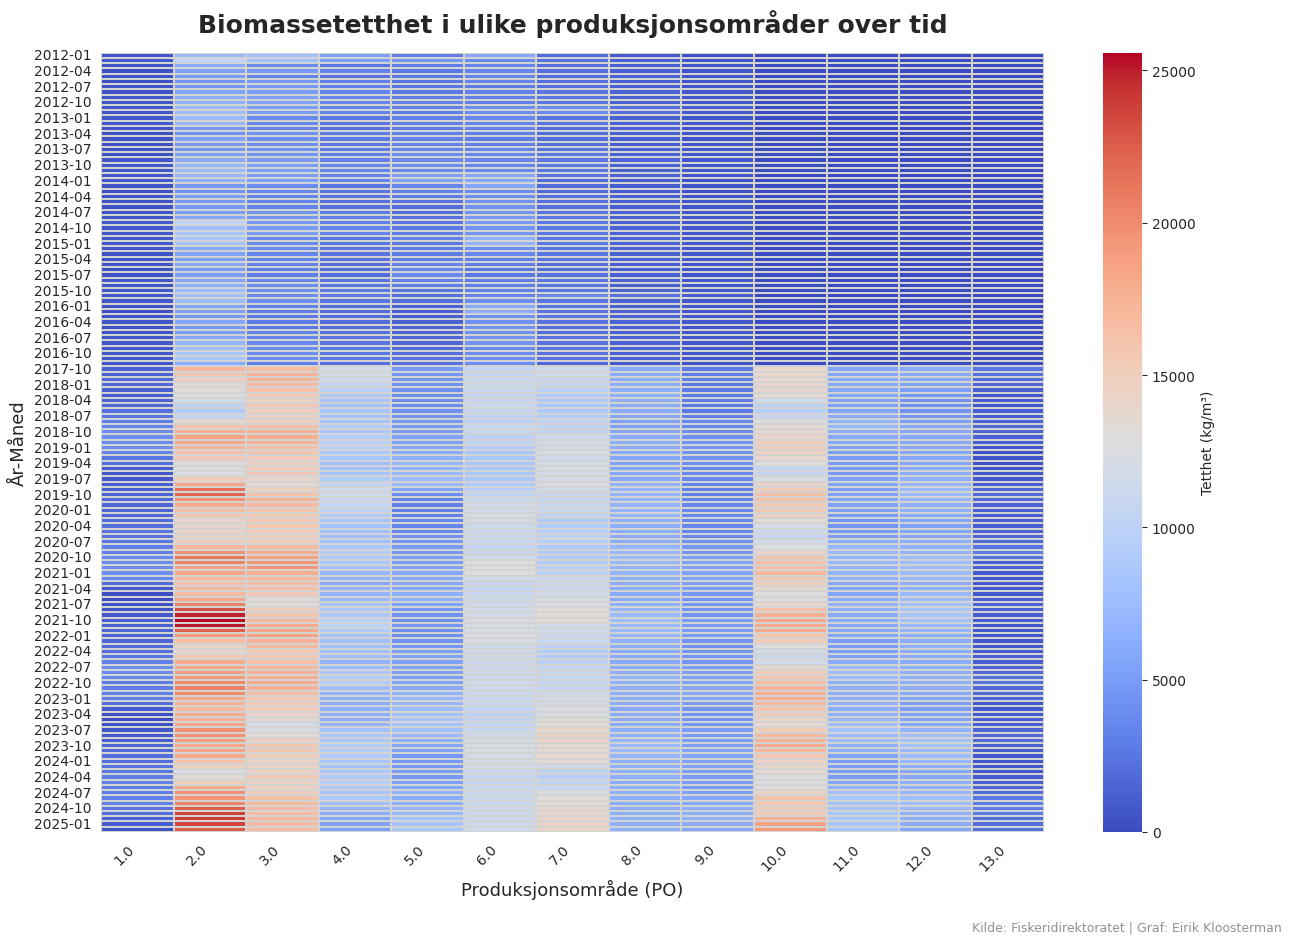

In [25]:



import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Stilinnstillinger
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Lato", "DejaVu Sans", "Arial"]

# Lag ÅrMnd-kolonne
df_full['ÅrMnd'] = df_full['Dato'].dt.to_period('M').astype(str)

# Pivotér data
heatmap_data = df_full.pivot_table(
    index="ÅrMnd",
    columns="PO",
    values="Tetthet",
    fill_value=0
)

# Lag heatmap
plt.figure(figsize=(13, 10))
ax = sns.heatmap(
    heatmap_data,
    cmap="coolwarm",  # Alternativ: "RdBu_r", "RdYlBu"
    linewidths=0.3,
    linecolor='lightgrey',
    cbar_kws={'label': 'Tetthet (kg/m³)'},
    square=False
)

# Tittel og akser
ax.set_title("Biomassetetthet i ulike produksjonsområder over tid", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Produksjonsområde (PO)", fontsize=13)
ax.set_ylabel("År-Måned", fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Kildetekst
plt.figtext(
    0.99, 0.01,
    "Kilde: Fiskeridirektoratet | Graf: Eirik Kloosterman",
    ha="right",
    va="bottom",
    fontsize=9,
    alpha=0.5
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()